In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests
from scipy.stats import chi2
from sklearn.metrics import balanced_accuracy_score, adjusted_mutual_info_score, brier_score_loss, mutual_info_score, accuracy_score
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
import os
os.chdir('/Users/lucblassel')

In [3]:
# to_load data
dirname = 'whole_dataset_figure_results'
averaged_preds = pd.read_csv(os.path.join(dirname, 'whole_dataset_averaged_preds.tsv'), sep='\t', index_col=0)
subset_preds = pd.read_csv(os.path.join(dirname, 'whole_dataset_subset_preds.tsv'), sep='\t', index_col=0)
cleaned_preds = pd.read_csv(os.path.join(dirname, 'whole_dataset_cleaned_preds.tsv'), sep='\t', index_col=0)

In [4]:
# grouper = ['task', 'dataset', 'subtype', 'shorthand', 'num']
grouper = ['task', 'dataset', 'subtype', 'shorthand']
# task_order = ['all features\nkept', 'DRM features\nremoved','DRM features &\nDRM sequences \nremoved']
task_order = ['all features\nkept', 'DRM features\nremoved', 'DRM features &\nDRM sequences\nremoved']

In [5]:
# change name of Fisher classifier
averaged_preds['shorthand'] = averaged_preds['shorthand'].apply(lambda x: {'B1': 'FC'}.get(x,x))
subset_preds['shorthand'] = subset_preds['shorthand'].apply(lambda x: {'B1': 'FC'}.get(x,x))
cleaned_preds['shorthand'] = cleaned_preds['shorthand'].apply(lambda x: {'B1': 'FC'}.get(x,x))

# Data cleaning / gathering
You can skip this ig the avove cells read precomputed tsv files

In [6]:
# all_preds = pd.read_csv('all_preds_with_boosting.tsv', sep='\t', index_col=0)
# all_preds = pd.read_csv('whole_dataset_all_preds.tsv', sep='\t', index_col=0)

In [7]:
# averaged = (all_preds.reset_index()
#     .groupby(grouper + ['index'])
#     .apply(lambda x: {k: round(x[k].mean()) for k in ['real', 'pred']})
# )

In [8]:
# averaged_preds = averaged.reset_index().set_index('index')
# averaged_preds.index = averaged_preds.index.astype(str)

In [9]:
# averaged_preds['real'] = averaged_preds[0].apply(lambda x: x['real'])
# averaged_preds['pred'] = averaged_preds[0].apply(lambda x: x['pred'])
# averaged_preds.head()

In [10]:
# subset_preds = averaged_preds[
#                 (averaged_preds['task'].isin(task_order)) & 
#                 (
#                     ((averaged_preds['dataset'] == 'UK') & (averaged_preds['subtype'].isin(['B', 'C']))) |
#                     ((averaged_preds['dataset'] == 'Africa') & (averaged_preds['subtype'] == 'ALL'))
#                 )
#             ]

In [11]:
# subset_preds.groupby(['task', 'dataset', 'subtype', 'shorthand'])['pred'].count()

In [12]:
metadata = pd.concat(
    [pd.read_csv(os.path.join('/Users/lucblassel/Documents/Work/hiv-drm-detection/data_pre_split',name), sep='\t', index_col=0)
    for name in ['uk-metadata.tsv', 'africa-metadata.tsv']]
)
metadata.index = metadata.index.astype(str)

In [13]:
# subset_preds.index = subset_preds.index.astype(str)
# subset_preds = subset_preds.join(metadata['hasDRM'])

In [14]:
# cleaned_preds = subset_preds[
#     ~((subset_preds['task'] == task_order[-1]) & 
#     (subset_preds['hasDRM'] == 1))
# ]

# Computing scores 
We need to compute AMI and/or balanced accuracy for the RF/LR/NB and fisher test based classifier on the 3 tasks. showing everything: 
 - trained on B, tested on C
 - trained on C, tested on B
 - trained on ALL, tested on Africa
 

In [15]:
def get_scores(df):
    scorer = {'AMI':adjusted_mutual_info_score, 'bal acc':balanced_accuracy_score, 'accuracy':accuracy_score}
    scores = {}
    for name, function in scorer.items():
        scores[name] = function(df['real'], df['pred'])
    return pd.Series(scores)

In [16]:
def get_pvalue(df):
    N = df.shape[0]
    m_i = mutual_info_score(df['real'], df['pred'])
    G_stat = m_i * 2 * N 
    return 1 - chi2.cdf(G_stat, df=1)

scores_cleaned: the sequences with DRMs are removed from the test set for models trained without them 

In [17]:
scores_cleaned = cleaned_preds.groupby(grouper).apply(get_scores)
p_values_cleaned = cleaned_preds.groupby(grouper).apply(get_pvalue).rename('p_value').reset_index()
melted_cleaned = pd.melt(scores_cleaned.reset_index(), id_vars=grouper)
melted_cleaned['group'] = melted_cleaned['task'] + ' ' + melted_cleaned['subtype']

In [18]:
scores = subset_preds.groupby(grouper).apply(get_scores)
p_values = subset_preds.groupby(grouper).apply(get_pvalue).rename('p_value').reset_index()
melted = pd.melt(scores.reset_index(), id_vars=grouper)
melted['group'] = melted['task'] + ' ' + melted['subtype']

In [19]:
def bonferroni(df, alpha=0.05):
    N = df.shape[0]
    df['bonferroni'] = df['p_value'] <= (alpha / N)
    return df

In [20]:
corrected_cleaned = p_values_cleaned.groupby('subtype').apply(bonferroni).set_index(['subtype', 'task', 'shorthand'])
corrected = p_values.groupby('subtype').apply(bonferroni).set_index(['subtype', 'task', 'shorthand'])

## Brier probas stuff

In [21]:
probas = pd.read_csv('all_preds_with_probas.tsv', sep='\t', index_col=0)

In [22]:
probas['shorthand'] = probas['shorthand'].apply(lambda x: {'B1': 'FC'}.get(x,x))

In [23]:
subset_probas = probas[
                (probas['task'].isin(task_order)) & 
                (
                    ((probas['dataset'] == 'UK') & (probas['subtype'].isin(['B', 'C']))) |
                    ((probas['dataset'] == 'Africa') & (probas['subtype'] == 'ALL'))
                )
            ]
subset_probas.index = subset_probas.index.astype(str)
subset_probas = subset_probas.join(metadata['hasDRM'])
subset_probas.head()

,pred,real,dir,subtype,target,model,dataset,num,0,1,task,shorthand,hasDRM
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,encoded_label,FisherBH1,Africa,0,NaN,NaN,all features\nkept,BH1,0.0
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,encoded_label,RF,Africa,19,0.904281,0.095719,all features\nkept,RF,0.0
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,encoded_label,Logistic,Africa,0,0.807977,0.192023,all features\nkept,LR,0.0
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,encoded_label,RF,Africa,6,0.904083,0.095917,all features\nkept,RF,0.0
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,encoded_label,FisherBonf2,Africa,0,NaN,NaN,all features\nkept,B2,0.0


In [24]:
cleaned_probas = subset_probas[
    ~((subset_probas['task'] == task_order[-1]) & 
    (subset_probas['hasDRM'] == 1))
]
cleaned_probas.head()

,pred,real,dir,subtype,target,model,dataset,num,0,1,task,shorthand,hasDRM
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,encoded_label,FisherBH1,Africa,0,NaN,NaN,all features\nkept,BH1,0.0
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,encoded_label,RF,Africa,19,0.904281,0.095719,all features\nkept,RF,0.0
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,encoded_label,Logistic,Africa,0,0.807977,0.192023,all features\nkept,LR,0.0
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,encoded_label,RF,Africa,6,0.904083,0.095917,all features\nkept,RF,0.0
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,encoded_label,FisherBonf2,Africa,0,NaN,NaN,all features\nkept,B2,0.0


In [25]:
def get_brier(df):
    model = df['shorthand'].iloc[0]
    if model not in ['NB', 'LR', 'RF']:
        return brier_score_loss(df['real'], df['pred'])
    else:
        return brier_score_loss(df['real'], df['1'])

def get_agnostic_brier(df):
    frequencies = {
        'all features\nkept':
            {'ALL':0.2452, 'B':0.2301, 'C':0.2773},
        'DRM features\nremoved':
            {'ALL':0.2452, 'B':0.2301, 'C':0.2773},
        'DRM features &\nDRM sequences\nremoved':
            {'ALL':0.1864, 'B':0.1729, 'C':0.2116}
    }
    subtype = df['subtype'].iloc[0]
    task = df['task'].iloc[0]
    return brier_score_loss(df['real'], [frequencies[task][subtype] for _ in df.index])


In [26]:
model_score = subset_probas.groupby(grouper+['num']).apply(get_brier).rename('brier').reset_index()
random_score = subset_probas[subset_probas['shorthand']=='NB'].groupby(grouper).apply(get_agnostic_brier).rename('brier').reset_index()
random_score['shorthand'] = 'RD'
scores_proba = pd.concat([model_score, random_score])
scores_proba['group'] = scores_proba['task'] + ' ' + scores_proba['subtype']

In [27]:
model_score_clean = cleaned_probas.groupby(grouper+['num']).apply(get_brier).rename('brier').reset_index()
random_score_clean = cleaned_probas[cleaned_probas['shorthand']=='NB'].groupby(grouper).apply(get_agnostic_brier).rename('brier').reset_index()
random_score_clean['shorthand'] = 'RD'
scores_proba_clean = pd.concat([model_score_clean, random_score_clean])
scores_proba_clean['group'] = scores_proba_clean['task'] + ' ' + scores_proba_clean['subtype']

# Accuracy stuff

In [28]:
def add_random_accuracies(accuracies, ax, line_args=dict()):
    y = [accuracies.loc[(task, sub)] for task in task_order for sub in subtypes for model in models]
    xmin, xmax = [], []
    for patch in ax.patches:
        xmin.append(patch.get_x())
        xmax.append(patch.get_x() + patch.get_width())
    ax.hlines(y, xmin, xmax, **line_args)

def get_theoretical_random_accuracy(df, iters=100, stratified=False):
    scores = []
    if stratified: 
        p = df['real'].value_counts(normalize=True).reindex([0,1]).fillna(0).values 
    else:
        p = [0.5, 0.5]
    for _ in range(iters):
        scores.append(accuracy_score(df['real'], np.random.choice([0,1], size=df.shape[0], p=p)))
    return sum(scores) / len(scores)

In [29]:
zero_class_accuracies = (subset_preds[subset_preds['shorthand']=='NB']
    .groupby(['task', 'subtype'])
    .apply(lambda x: accuracy_score(x['real'], [0 for _ in x['real']])))

zero_class_accuracies_clean = (cleaned_preds[cleaned_preds['shorthand']=='NB']
    .groupby(['task', 'subtype'])
    .apply(lambda x: accuracy_score(x['real'], [0 for _ in x['real']])))

random_accuracies = (subset_preds[subset_preds['shorthand']=='NB']
    .groupby(['task', 'subtype'])
    .apply(lambda x: get_theoretical_random_accuracy(x, iters=1000, stratified=True)))

## Plot preparation

In [30]:
# models = ['NB', 'LR', 'RF', 'FisherBonf1']
models = ['NB', 'LR', 'RF', 'FC']
subtypes = ['ALL', 'B', 'C']
subtype_labels = {
    'ALL': 'trained on UK B&C,\ntested on Africa',
    'B': 'trained on UK B,\ntested on UK C',
    'C': 'trained on UK C,\ntested on UK B'
}

In [56]:
colors = [color for color in sns.palettes.color_palette('muted') for _ in range(3)]
hue_order = [f"{task} {sub}" for task in task_order for sub in subtypes]

In [57]:
repeats = {'big': 3, 'small':4}
patterns = {k:{'B':'/'*n, 'C': '\\'*n} for k,n in repeats.items()} 
hatches = [patterns['big'].get(sub, None) for task in task_order for sub in subtypes for model in models]
small_hatches = [patterns['small'].get(sub, None) for task in task_order for sub in subtypes for model in models]
models_ext = models + ['RD']
hatches_ext = [patterns.get(sub, None) for task in task_order for sub in subtypes for model in models_ext]

In [33]:
sns.set_context('poster')
sns.set_palette('muted')

In [34]:
task_handles = [
    Patch(facecolor=color, label=task, lw=1.5, edgecolor='black')
    for color, task in zip(sns.color_palette(), task_order)
    ]
subtype_handles = [
    Patch(
        facecolor="white",
        label=subtype_labels.get(subtype),
        hatch=patterns['small'].get(subtype, ""),
        lw=1.5, edgecolor='black',
    )
    for subtype in subtypes
    ]

legend_handles = (
    [Patch(color="white", label="signal removal:")]
    + task_handles
    + [
        # Patch(color="white", label=""),
        Patch(color="white", label="training scenario:"),
    ]
    + subtype_handles
)

In [35]:
random_handles = (
    Patch(color='white', label=""),
    Line2D([0], [0], color='red', label="expected value\nfor null classifier"),
    Patch(color='white', label=""),
    Patch(color='white', label=""),
)

In [36]:
def get_legend(gen_label=False, context='notebook'):
    with sns.plotting_context(context):
        tasks = ['all features\nkept\n', 'DRM features\nremoved\n', 'DRM features &\nDRM sequences\nremoved']
        h1 = [Patch(facecolor=color, label=task, edgecolor='black') for task, color in zip(tasks, sns.color_palette())]
        h2 = [Patch(facecolor="white",label=subtype_labels.get(subtype),hatch=patterns['small'].get(subtype, ""), 
                edgecolor='black',) for subtype in subtypes]
        l = Line2D([0], [0], color='red', label="expected value\nfor null classifier\n")
        e = Patch(color='white', label="")
        labels = [Patch(color="white", label="signal removal:\n\n"), Patch(color="white", label="training scenario:\n")]
    (ncol, handles) = (5, labels) if gen_label else (4, [])
    return (ncol, 
        handles + [h1[0], h2[0]] + [h1[1], h2[1]] + [h1[2], h2[2]] + [l, e]
    )

In [37]:
def test_legend():
    with sns.plotting_context('notebook'):
        tasks = ['all features\nkept\n', 'DRM features\nremoved\n', 'DRM features &\nDRM sequences\nremoved']
        h1 = [Patch(facecolor='white', label=task, edgecolor='black') for task in tasks]
        h2 = [Patch(facecolor="white",label=subtype_labels.get(subtype),hatch=patterns['small'].get(subtype, ""),
                 edgecolor='black',) for subtype in subtypes]
        l = Line2D([0], [0], color='black', label="expected value\nfor null classifier\n")
        e = Patch(facecolor='white', edgecolor='white', label="")
        return (4, #5, 
            # [Patch(facecolor="white", edgecolor='gray', label="signal removal:\n\n"), 
            #  Patch(facecolor="white", edgecolor='gray', label="training scenario:\n")] +
            [h1[0], h2[0]] + [h1[1], h2[1]] + [h1[2], h2[2]] + [l, e]
        )

# Plotting scores

In [38]:
def get_subplot(to_plot, ylabel, annots=None, x='shorthand', y='value', hue='group', order=models, palette=colors, hue_order=hue_order, hatches=hatches, ax=None, title="", title_args=dict(), yticks=None, ylim=None, log=False, xlabel="Classifier"):
    
    kwargs={'ax':ax} if ax is not None else {}
        
    ax = sns.barplot(
        data=to_plot, 
        x=x, 
        y=y,
        hue=hue, 
        order=order,
        hue_order=hue_order, 
        palette=palette, 
        # lw=1.2,
        edgecolor='black',
        ci=None,
        **kwargs
    )
    if annots is None:
        annots = ["" for _ in hatches]
    for patch, hatch, annot in zip(ax.patches, hatches, annots):
        if annot == "*":
            x = patch.get_x() + patch.get_width() / 2
            if log:
                y = (patch.get_y() + patch.get_height()) * 1.05
            else:
                y = (patch.get_y() + patch.get_height()) + 0.01
            ax.text(x, y, annot, ha='center')
        if hatch is None:
            continue 
        patch.set_hatch(hatch)

    sns.despine()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.get_legend().remove()
    ax.set_title(title, **title_args)
    if yticks is not None:
        ax.set_yticks(yticks)
    if log:
        ax.set_yscale('log')
    if ylim is not None:
        ax.set_ylim(ylim)
    return ax

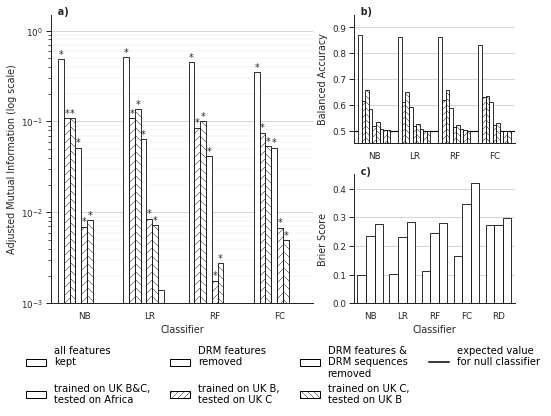

In [39]:
whites = [(1.0, 1.0, 1.0) for i in range(10)]

sns.set_context('paper')
mpl.rcParams['hatch.linewidth'] = 0.4
fig = plt.figure(figsize=(8.3, 5.8))
annots_cleaned = ["*" if corrected_cleaned['bonferroni'].get((sub, task, model), False) else "" 
                    for task in task_order for sub in subtypes for model in models]
title_args = {'loc':'left', 'fontweight':'bold', 'pad':0}
ami_ticks = np.linspace(0, 0.55, 12)
acc_ticks = np.linspace(0.5, 0.9, 5)
brier_ticks = np.linspace(0, 0.4, 5)

to_plot_AMI = melted_cleaned[(melted_cleaned['shorthand'].isin(models)) & (melted_cleaned['variable'] == 'AMI')]
to_plot_bal = melted_cleaned[(melted_cleaned['shorthand'].isin(models)) & (melted_cleaned['variable'] == 'bal acc')]
to_plot_brier = scores_proba[(scores_proba['shorthand'].isin(models + ['RD'])) & (scores_proba['subtype'] == 'ALL')]

with sns.axes_style('white', {'grid.color':'.8', 'axes.grid':True, 'ytick.left':True}):
    ax1 = plt.subplot2grid((12, 5), (0, 0), colspan=3, rowspan=11)
    ax1.grid(b=True, which='minor', color='.8', lw=0.2)
    get_subplot(to_plot_AMI, 'Adjusted Mutual Information (log scale)', annots=annots_cleaned, ax=ax1, title='  a)', 
                title_args=title_args, yticks=ami_ticks, ylim=(1e-3, 1.5), log=True, palette=whites)

    ax2 = plt.subplot2grid((12, 5), (0, 3), colspan=2, rowspan=5)
    ax3 = plt.subplot2grid((12, 5), (6, 3), colspan=2, rowspan=5)
    ax2.axhline(y=0.5, ls='-', color='black', zorder=0.9)
    get_subplot(to_plot_bal, 'Balanced Accuracy', ax=ax2, title='  b)', title_args=title_args, 
                yticks=acc_ticks, hatches=small_hatches, ylim=(0.45,0.95), palette=whites, xlabel="")
    get_subplot(to_plot_brier, 'Brier Score', ax=ax3, title='  c)', title_args=title_args, 
                hue_order=[hue_order[i] for i in [0,3,6]], hatches=[], y='brier', palette=whites, 
                order=models + ['RD'], ylim=(0, 0.45), yticks=brier_ticks)
    
ax4 = plt.subplot2grid((12, 5), (11, 0), colspan=5)
ax4.axis('off')
ncol, handles = test_legend()
ax4.legend(handles=handles, ncol=ncol, bbox_to_anchor=(0.5, -0.5), loc='upper center', borderaxespad=0, frameon=False, 
            prop={'size':10})

plt.subplots_adjust(wspace=0.7)
plt.savefig(os.path.join(dirname, 'layout_tester.pdf'), format='pdf', alpha=.99, bbox_inches='tight')

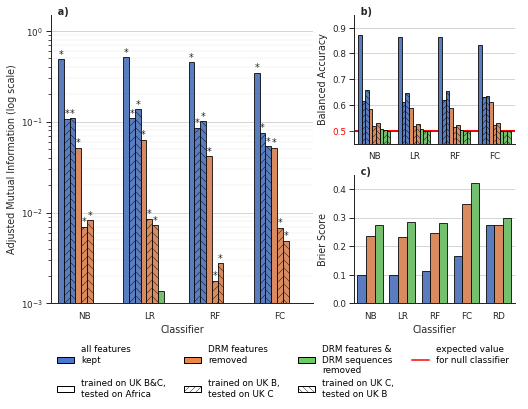

In [77]:
sns.set_context('paper')
mpl.rcParams['hatch.linewidth'] = 0.4
fig = plt.figure(figsize=(8.3, 5.8))
annots_cleaned = ["*" if corrected_cleaned['bonferroni'].get((sub, task, model), False) else "" 
                    for task in task_order for sub in subtypes for model in models]
title_args = {'loc':'left', 'fontweight':'bold', 'pad':0}
ami_ticks = np.linspace(0, 0.55, 12)
acc_ticks = np.linspace(0.5, 0.9, 5)
brier_ticks = np.linspace(0, 0.4, 5)

to_plot_AMI = melted_cleaned[(melted_cleaned['shorthand'].isin(models)) & (melted_cleaned['variable'] == 'AMI')]
to_plot_bal = melted_cleaned[(melted_cleaned['shorthand'].isin(models)) & (melted_cleaned['variable'] == 'bal acc')]
to_plot_brier = scores_proba[(scores_proba['shorthand'].isin(models + ['RD'])) & (scores_proba['subtype'] == 'ALL')]

with sns.axes_style('white', {'grid.color':'.8', 'axes.grid':True, 'ytick.left':True}):
    ax1 = plt.subplot2grid((12, 5), (0, 0), colspan=3, rowspan=11)
    get_subplot(to_plot_AMI, 'Adjusted Mutual Information (log scale)', annots=annots_cleaned, ax=ax1, title='  a)', 
                title_args=title_args, yticks=ami_ticks, ylim=(1e-3, 1.5), log=True)
    ax2 = plt.subplot2grid((12, 5), (0, 3), colspan=2, rowspan=5)
    ax3 = plt.subplot2grid((12, 5), (6, 3), colspan=2, rowspan=5)
    ax2.axhline(y=0.5, ls='-', color='red', zorder=0.9, lw=2)
    ax2.get_yticklabels()[0].set_color("red")
    ax2.get_yticklines()[0].set_color("red")
    get_subplot(to_plot_bal, 'Balanced Accuracy', ax=ax2, title='  b)', title_args=title_args, 
                yticks=acc_ticks, hatches=small_hatches, ylim=(0.45,0.95), xlabel="")
    get_subplot(to_plot_brier, 'Brier Score', ax=ax3, title='  c)', title_args=title_args, 
                hue_order=[hue_order[i] for i in [0,3,6]], hatches=[], y='brier', palette=sns.color_palette(),
                order=models + ['RD'], ylim=(0, 0.45), yticks=brier_ticks)

ax1.grid(b=True, which='minor', color='.8', lw=0.2)

ax4 = plt.subplot2grid((12, 5), (11, 0), colspan=5)
ax4.axis('off')
ncol, handles = get_legend()
ax4.legend(handles=handles, ncol=ncol,  bbox_to_anchor=(0.5, -0.5), loc='upper center', borderaxespad=0, frameon=False)

plt.subplots_adjust(wspace=0.7)
plt.savefig(os.path.join(dirname, 'perf_log_tight.pdf'), format='pdf', alpha=.99, bbox_inches='tight')

## Remove non mutated sequences

In [41]:
mutated_preds = subset_preds[subset_preds['hasDRM'] == 1]
mutated_preds.head()

,task,dataset,subtype,shorthand,0,real,pred,hasDRM
0002_BI01t_BI_C_102_1019_T,DRM features\nremoved,Africa,ALL,FC,"{'real': 1.0, 'pred': 0.0}",1.0,0.0,1.0
0002_BI01t_BI_C_102_1019_T,DRM features\nremoved,Africa,ALL,B2,"{'real': 1.0, 'pred': 0.0}",1.0,0.0,1.0
0002_BI01t_BI_C_102_1019_T,DRM features\nremoved,Africa,ALL,BH1,"{'real': 1.0, 'pred': 0.0}",1.0,0.0,1.0
0002_BI01t_BI_C_102_1019_T,DRM features\nremoved,Africa,ALL,BH2,"{'real': 1.0, 'pred': 0.0}",1.0,0.0,1.0
0002_BI01t_BI_C_102_1019_T,DRM features\nremoved,Africa,ALL,D1,"{'real': 1.0, 'pred': 0.0}",1.0,0.0,1.0


In [42]:
scores_mutated = mutated_preds.groupby(grouper).apply(get_scores)
p_values_mutated = mutated_preds.groupby(grouper).apply(get_pvalue).rename('p_value').reset_index()
melted_mutated = pd.melt(scores_mutated.reset_index(), id_vars=grouper)
melted_mutated['group'] = melted_mutated['task'] + ' ' + melted_mutated['subtype']

In [43]:
corrected_mutated = p_values_mutated.groupby('subtype').apply(bonferroni).set_index(['subtype', 'task', 'shorthand'])

In [44]:
zero_class_accuracies_mutated = (mutated_preds[mutated_preds['shorthand']=='NB']
    .groupby(['task', 'subtype'])
    .apply(lambda x: accuracy_score(x['real'], [0 for _ in x['real']])))

In [45]:
mutated_probas = probas[
                (probas['task'].isin(task_order)) & 
                (
                    ((probas['dataset'] == 'UK') & (probas['subtype'].isin(['B', 'C']))) |
                    ((probas['dataset'] == 'Africa') & (probas['subtype'] == 'ALL'))
                )
            ]
mutated_probas.index = mutated_probas.index.astype(str)
mutated_probas = mutated_probas.join(metadata['hasDRM'])
mutated_probas = mutated_probas[mutated_probas['hasDRM'] == 1]
mutated_probas.head()

,pred,real,dir,subtype,target,model,dataset,num,0,1,task,shorthand,hasDRM
0002_BI01t_BI_C_102_1019_T,1,1,results_whole_training_set,ALL,encoded_label,FisherBH1,Africa,0,NaN,NaN,all features\nkept,BH1,1.0
0002_BI01t_BI_C_102_1019_T,1,1,results_whole_training_set,ALL,encoded_label,RF,Africa,19,0.147272,0.852728,all features\nkept,RF,1.0
0002_BI01t_BI_C_102_1019_T,1,1,results_whole_training_set,ALL,encoded_label,Logistic,Africa,0,0.050446,0.949554,all features\nkept,LR,1.0
0002_BI01t_BI_C_102_1019_T,1,1,results_whole_training_set,ALL,encoded_label,RF,Africa,6,0.139313,0.860687,all features\nkept,RF,1.0
0002_BI01t_BI_C_102_1019_T,1,1,results_whole_training_set,ALL,encoded_label,FisherBonf2,Africa,0,NaN,NaN,all features\nkept,B2,1.0


In [47]:
model_score_mutated = mutated_probas.groupby(grouper+['num']).apply(get_brier).rename('brier').reset_index()
random_score_mutated = mutated_probas[mutated_probas['shorthand']=='NB'].groupby(grouper).apply(get_agnostic_brier).rename('brier').reset_index()
random_score_mutated['shorthand'] = 'RD'
scores_proba_mutated = pd.concat([model_score_mutated, random_score_mutated])
scores_proba_mutated['group'] = scores_proba_mutated['task'] + ' ' + scores_proba_mutated['subtype']

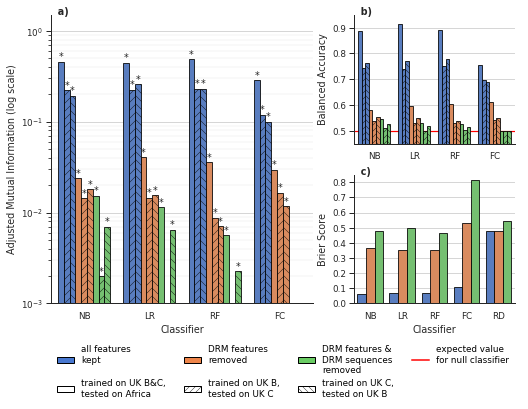

In [48]:
sns.set_context('paper')
mpl.rcParams['hatch.linewidth'] = 0.4
fig = plt.figure(figsize=(8.3, 5.8))
annots_cleaned = ["*" if corrected_mutated['bonferroni'].get((sub, task, model), False) else "" 
                    for task in task_order for sub in subtypes for model in models]
title_args = {'loc':'left', 'fontweight':'bold', 'pad':0}
ami_ticks = np.linspace(0, 0.55, 12)
acc_ticks = np.linspace(0.5, 0.9, 5)
brier_ticks = np.linspace(0, 0.8, 9)

to_plot_AMI = melted_mutated[(melted_mutated['shorthand'].isin(models)) & (melted_mutated['variable'] == 'AMI')]
to_plot_bal = melted_mutated[(melted_mutated['shorthand'].isin(models)) & (melted_mutated['variable'] == 'bal acc')]
to_plot_brier = scores_proba_mutated[(scores_proba_mutated['shorthand'].isin(models + ['RD'])) & (scores_proba_mutated['subtype'] == 'ALL')]

with sns.axes_style('white', {'grid.color':'.8', 'axes.grid':True, 'ytick.left':True}):
    ax1 = plt.subplot2grid((12, 5), (0, 0), colspan=3, rowspan=11)
    get_subplot(to_plot_AMI, 'Adjusted Mutual Information (log scale)', annots=annots_cleaned, ax=ax1, title='  a)', 
                title_args=title_args, yticks=ami_ticks, ylim=(1e-3, 1.5), log=True)
    ax2 = plt.subplot2grid((12, 5), (0, 3), colspan=2, rowspan=5)
    ax3 = plt.subplot2grid((12, 5), (6, 3), colspan=2, rowspan=5)
    ax2.axhline(y=0.5, ls='-', color='red', zorder=0.9)
    get_subplot(to_plot_bal, 'Balanced Accuracy', ax=ax2, title='  b)', title_args=title_args, 
                yticks=acc_ticks, hatches=small_hatches, ylim=(0.45,0.95), xlabel="")
    get_subplot(to_plot_brier, 'Brier Score', ax=ax3, title='  c)', title_args=title_args, 
                hue_order=[hue_order[i] for i in [0,3,6]], hatches=[], y='brier', palette=sns.color_palette(),
                order=models + ['RD'], ylim=(0, 0.85), yticks=brier_ticks)

ax1.grid(b=True, which='minor', color='.8', lw=0.2)

ax4 = plt.subplot2grid((12, 5), (11, 0), colspan=5)
ax4.axis('off')
ncol, handles = get_legend()
ax4.legend(handles=handles, ncol=ncol,  bbox_to_anchor=(0.5, -0.5), loc='upper center', borderaxespad=0, frameon=False)

plt.subplots_adjust(wspace=0.7)

In [49]:
melted_mutated['muts'] = 'muts'
melted_cleaned['muts'] = 'clean'
concated = pd.concat([melted_cleaned, melted_mutated], axis=0)
concated['group2'] = concated['subtype'] + concated['muts']

In [50]:
alternate_handles = [
    Patch(facecolor='white', label='test set:'),
    Patch(facecolor=colors[0], label='all sequences', edgecolor='black'),
    Patch(facecolor=colors[3], label='only sequences\nwith DRMs', edgecolor='black'),
]

['ALLclean', 'ALLmuts', 'Bclean', 'Bmuts', 'Cclean', 'Cmuts']

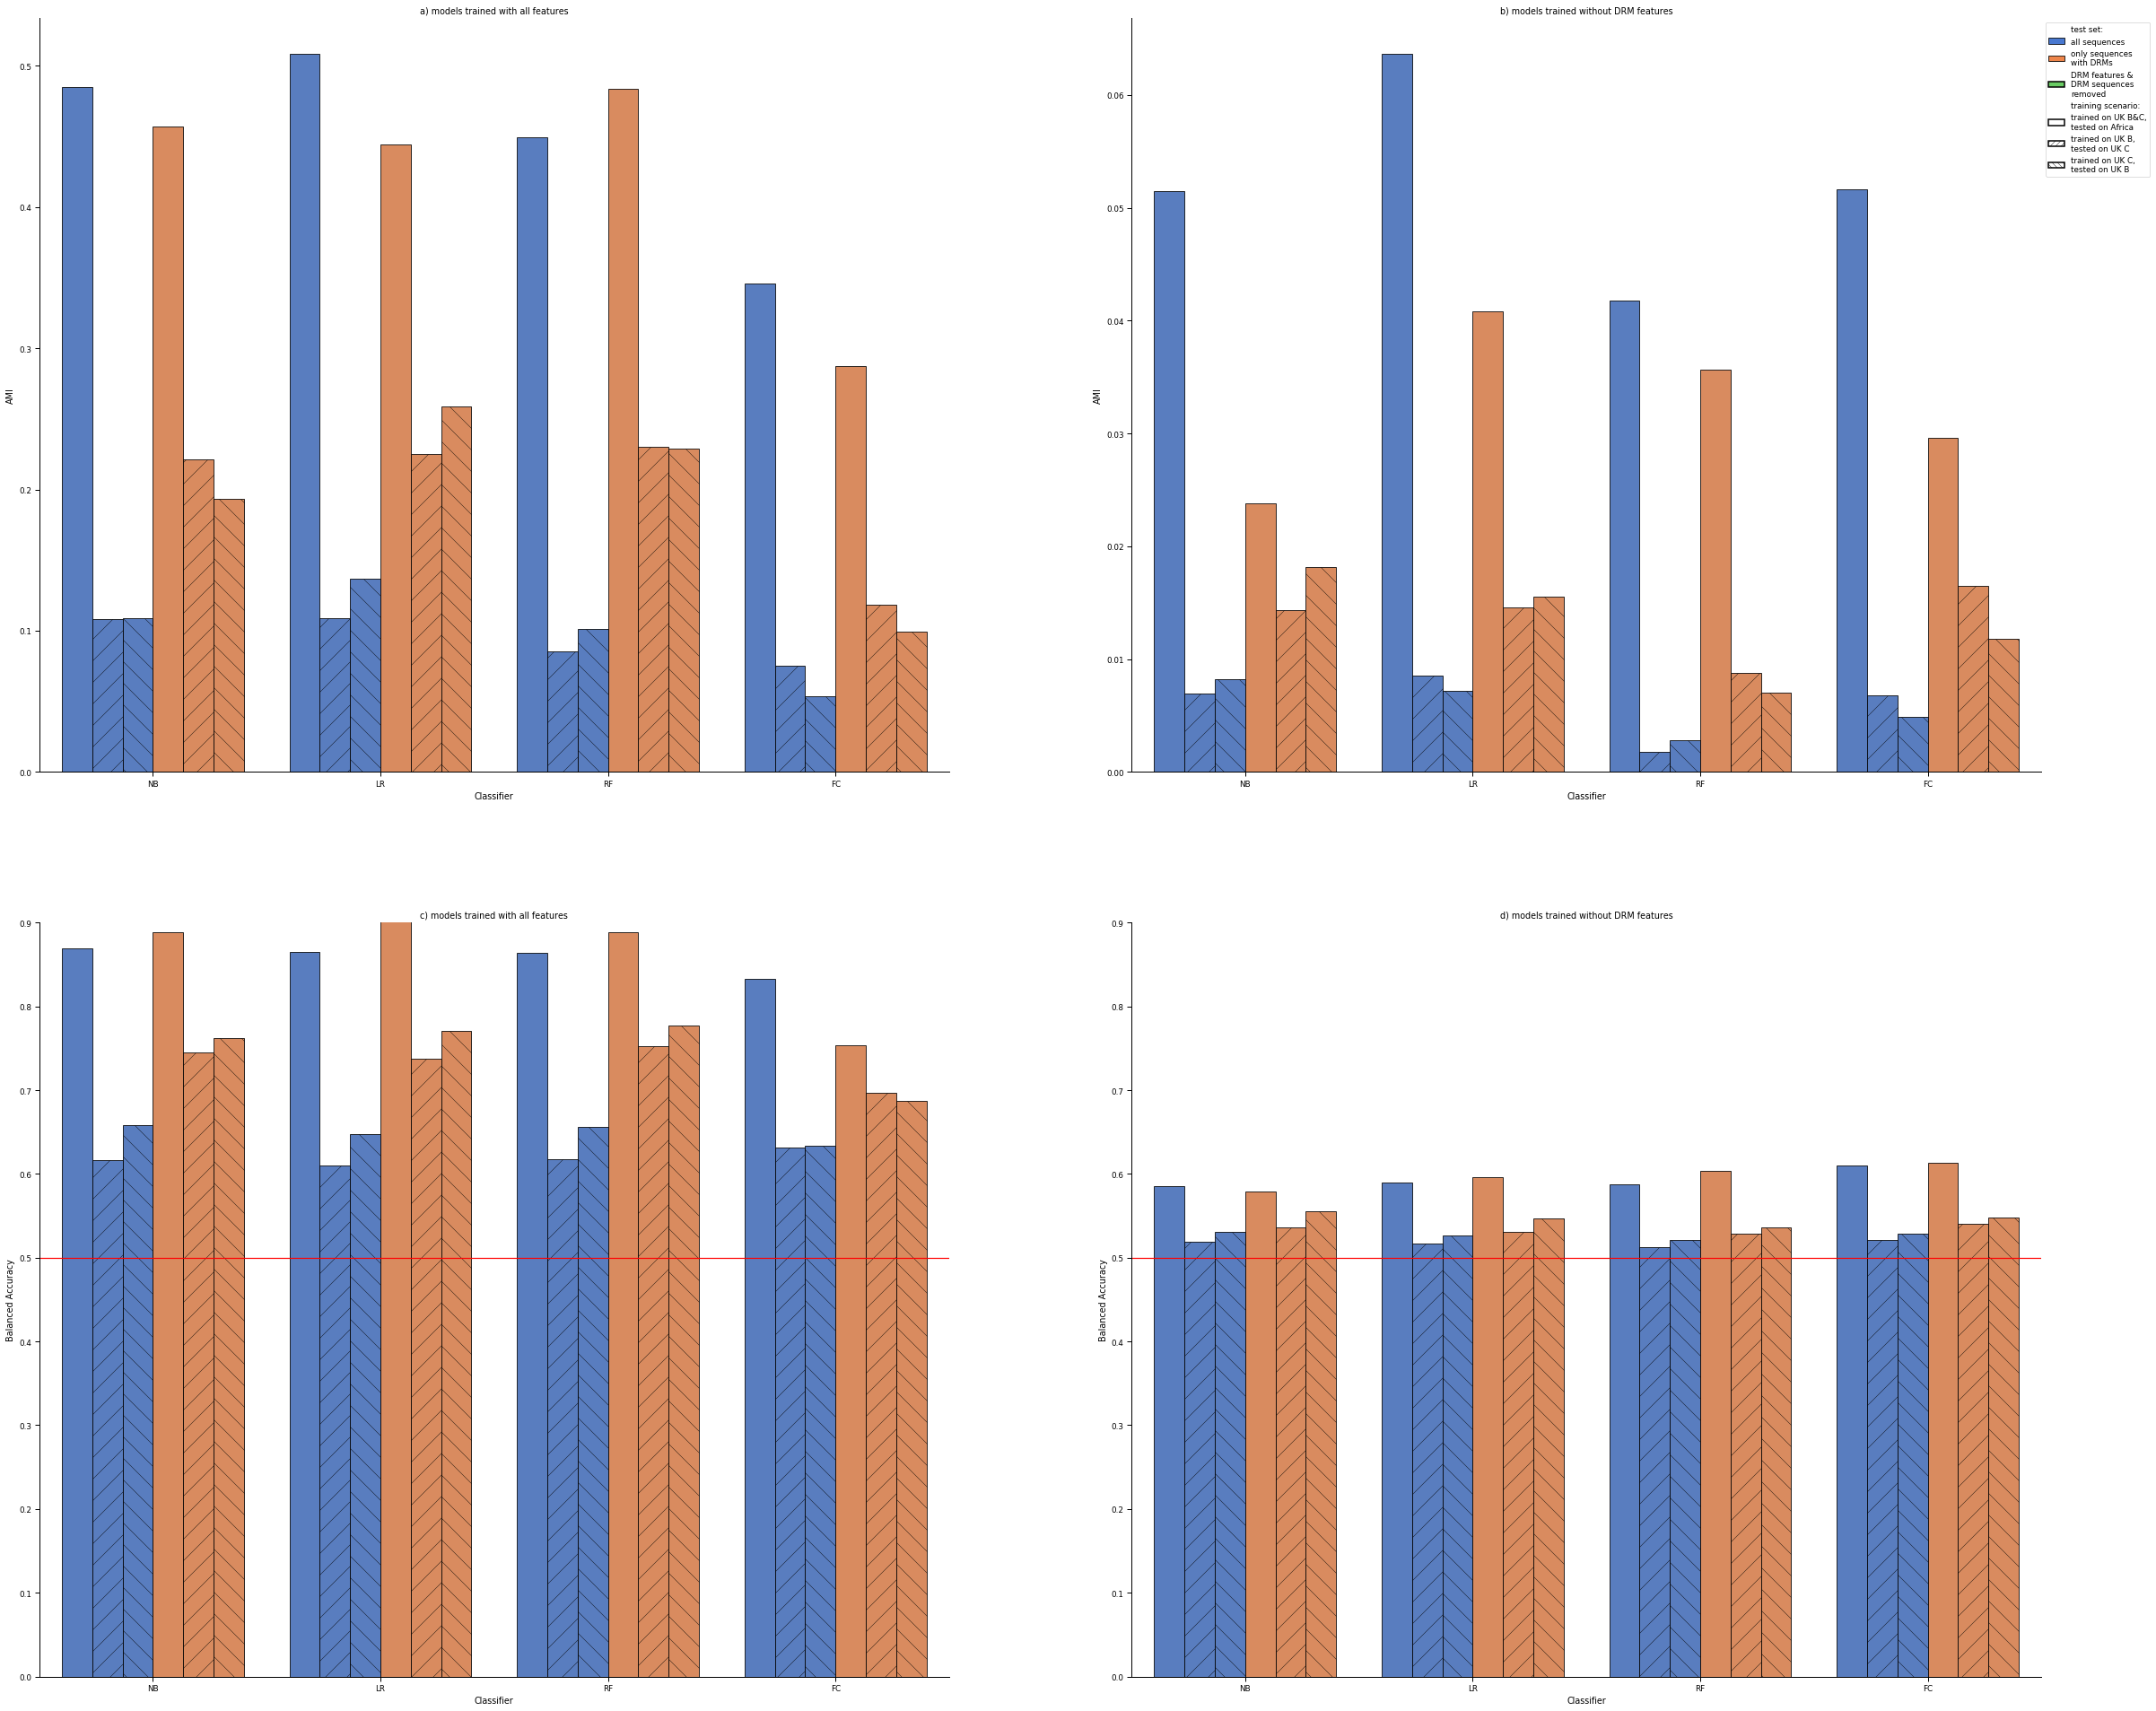

In [51]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20*2, 17*2))

hue_order_2 =[s+m for m in ['clean', 'muts'] for s in subtypes]
hatches_2 = [p for _ in range (2) for p in ['','/','\\'] for _ in range(4)]

ami_all_features = concated[(concated['task'] == task_order[0]) & (concated['variable'] == 'AMI')]
ami_no_DRMs = concated[(concated['task'] == task_order[1]) & (concated['variable'] == 'AMI')]
bal_all_features = concated[(concated['task'] == task_order[0]) & (concated['variable'] == 'bal acc')]
bal_no_DRMs = concated[(concated['task'] == task_order[1]) & (concated['variable'] == 'bal acc')]

ax1 = get_subplot(ami_all_features, 'AMI', x='shorthand', order=models, hue='group2', palette=colors, y='value', hatches=hatches_2, hue_order=hue_order_2, title='a) models trained with all features', ax=ax1)
ax2 = get_subplot(ami_no_DRMs, 'AMI', x='shorthand', order=models, hue='group2', palette=colors, y='value', hatches=hatches_2, hue_order=hue_order_2, title='b) models trained without DRM features', ax=ax2)
ax3 = get_subplot(bal_all_features, 'Balanced Accuracy', x='shorthand', order=models, hue='group2', palette=colors, y='value', hatches=hatches_2, hue_order=hue_order_2, title='c) models trained with all features', ax=ax3)
ax4 = get_subplot(bal_no_DRMs, 'Balanced Accuracy', x='shorthand', order=models, hue='group2', palette=colors, y='value', hatches=hatches_2, hue_order=hue_order_2, title='d) models trained without DRM features', ax=ax4)

for ax in (ax3, ax4):
    ax.axhline(y=0.5, color='red', ls='-')
    ax.set_ylim((0, 0.9))

ax2.legend(handles=alternate_handles + legend_handles[-5:], bbox_to_anchor=(1, 1), loc='upper left',)
plt.savefig(os.path.join(dirname, 'Performance_comparison_all_seqs_and_only_DRM_seqs.pdf'), format='pdf', alpha=.99, bbox_inches='tight')

In [52]:
# # annots_cleaned = ["*" if corrected_cleaned['bonferroni'].get((sub, task, model), 1) <= 0.05 else "" for task in task_order for sub in subtypes for model in models]
# annots_cleaned = ["*" if corrected_cleaned['bonferroni'].get((sub, task, model), False) else "" for task in task_order for sub in subtypes for model in models]
# to_plot = melted_cleaned[(melted_cleaned['shorthand'].isin(models)) & (melted_cleaned['variable'] == 'AMI')]
# sns.set_context('poster')
# fig, ax = plt.subplots(1, figsize=(20, 17))
# ax = sns.barplot(
#     data=to_plot, 
#     x='shorthand', 
#     y='value',
#     hue='group', 
#     order=models,
#     hue_order=hue_order, 
#     palette=colors, 
#     lw=1.5,
#     edgecolor='black',
#     ax=ax,
# )

# for patch, hatch, annot in zip(ax.patches, hatches, annots_cleaned):
#     if annot == "*":
#         x = patch.get_x() + patch.get_width() / 2
#         y = (patch.get_y() + patch.get_height()) + 0.01
#         ax.text(x, y, annot, ha='center')
#     if hatch is None:
#         continue 
#     patch.set_hatch(hatch)

# # plt.yscale('log')
# # plt.ylim((1e-5, 1))
# sns.despine()
# plt.xlabel('Classifier')
# plt.ylabel('Adjusted Mutual Information')
# plt.legend(handles=legend_handles,  bbox_to_anchor=(1, 0.5), loc='center left',)
# plt.savefig(os.path.join(dirname, 'AMI_cleaned_linear.pdf'), format='pdf', alpha=.99, bbox_inches='tight')